## **download library and install library**

In [ ]:
!pip install torch==1.10.0+cu102 torchvision==0.11.1+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
!pip install mmdet==2.17.0
!pip install icevision[all]
!pip install fastbook
!pip install gradio
!pip install icedata
!pip install progressbar2
!pip install tqdm

In [30]:
import json
import ast
import pandas as pd
import os.path as op
from pathlib import Path
from PIL import Image
from icevision.models import *
from icevision.all import *
import icedata
import PIL, requests
import torch
from torchvision import transforms
import gradio as gr
from fastbook import *
from fastai.vision.all import *
import os.path as op
import pandas as pd
from icevision.all import *
import torch
import torchvision.transforms.functional as fn
from PIL import Image
from torchvision.transforms.functional import crop
import cv2
import numpy as np
from tqdm import tqdm
from time import sleep

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **multi images**

In [24]:
cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/result1_obj_detection

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/result1_obj_detection


In [ ]:
# โหลดโมเดลที่เซฟมาเพื่อทำนายผลใน validation set
model_loaded = model_from_checkpoint("./model_OBJ/mangda_det_240.pth")
learn_BF = load_learner('./model_back_front/VGG16_fastai.pkl')
learn_B = load_learner('./model_back/densenet201_fastai.pkl')
learn_F = load_learner('./model_front/resnext50_fastai.pkl')
#load image
path_to_image_folder = "./images/test"
img_files = get_image_files(path_to_image_folder)
#settings model
model = model_loaded['model']
model_type = model_loaded["model_type"]
backbone = model_loaded["backbone"]
class_map = model_loaded["class_map"]
img_size = model_loaded["img_size"]
model_type, backbone, class_map, img_size
#resize image
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad((img_size,img_size)), tfms.A.Normalize()])
#count image
num_img = 1
#img to img array
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files[0:1]]
#Predict image 
Pre_imgs_array = []

for img in tqdm(imgs_array):
  pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.7)
  print("ภาพที่ %.2f" %num_img)
  img_out = img
  img_out = np.array(img_out)
  Boxes_Pre = pred_dict['detection']['bboxes']

  for i in tqdm(range(len(Boxes_Pre))):
    #change BBox to list
    pre = Boxes_Pre[i-1]
    BBox_tensor = pre.to_tensor()
    BBox_list= BBox_tensor.tolist()
    # Setting the points for cropped image
    xmin = int(BBox_list[0])
    ymin = int(BBox_list[1])
    xmax = int(BBox_list[2])
    ymax = int(BBox_list[3])
    # crop image
    im1 = img.crop((xmin, ymin, xmax, ymax))
    im1.show()
    # im1.show()
    im1.resize((224,224))
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    im1 = trans(trans1(im1))
    im2 = np.array(im1)
    Pre_BF = learn_BF.predict(im2)[0]
    # predict back or front
    if Pre_BF == 'front' :#ทายเป็นด้านหน้า
          classes = ['Carcinoscorpius_rotundicauda', 'Tachypleus_gigas']
          #ทายชนิด
          Pre_F = learn_F.predict(im2)
          prop_F = Pre_F[2].max()
          prop_float = prop_F.item()
          #weight predict 
          if prop_float > 0.6 : 
            print('class:',Pre_F[0], ",accuracy =", '%.3f' %prop_float)
            # Draw draw boxes
            cv2.rectangle(img_out, (xmin,ymin), (xmax,ymax), (255,0,0), 3)
            cv2.putText(img_out, 
                   Pre_F[0], 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * int(pred_dict['height']), 
                    (255,0,0), 2)
            
          else:# เปอร์เซ็นต์การทายน้อยกว่า 0.6
            classes.remove(Pre_F[0])#นำคลาสที่ทายออก แล้วนำ
            print('class:',classes[0])
            # Draw draw boxes
            cv2.rectangle(img_out, (xmin,ymin), (xmax,ymax), (255,0,0), 3)
            cv2.putText(img_out, 
                   classes[0], 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * int(pred_dict['height']), 
                    (255,0,0), 2)
          sleep(.1)

    else:#ถายเป็นด้านหลัง
          classes = ['Carcinoscorpius_rotundicauda', 'Tachypleus_gigas']
          Pre_B = learn_B.predict(im2)
          prop_B = Pre_B[2].max()
          prop_float = prop_B.item()
          if prop_float > 0.5 :#weight predict 
            print('class:',Pre_B[0], ",accuracy =", '%.3f' %prop_float)
            # Draw draw boxes
            cv2.rectangle(img_out, (xmin,ymin), (xmax,ymax), (255,0,0), 3)
            cv2.putText(img_out, 
                   Pre_B[0], 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * int(pred_dict['height']), 
                    (255,0,0), 2)
          else:
            classes.remove(Pre_B[0])
            print('class:',classes[0])
            # Draw draw boxes
            cv2.rectangle(img_out, (xmin,ymin), (xmax,ymax), (255,0,0), 3)
            cv2.putText(img_out, 
                   classes[0], 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * int(pred_dict['height']), 
                    (255,0,0), 2)
          sleep(.1)

  img_out = Image.fromarray(img_out)
  display(img_out)
  Pre_imgs_array.append(img_out)
  img_out = img_out.save("prediction " + str(num_img) + '.png')
  num_img = num_img +1
  sleep(0.1)

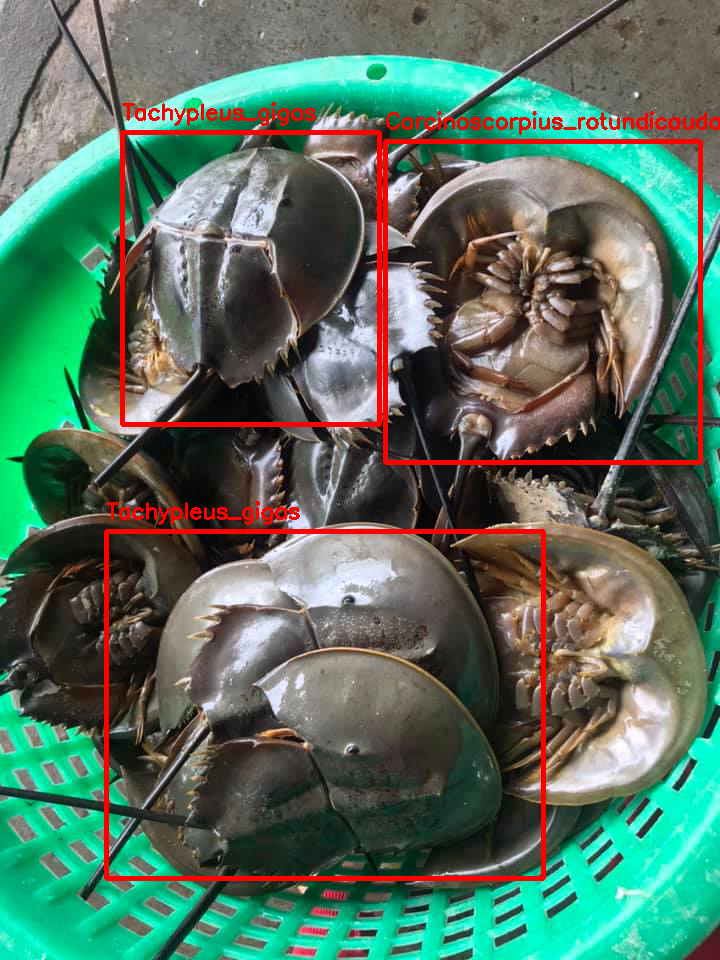

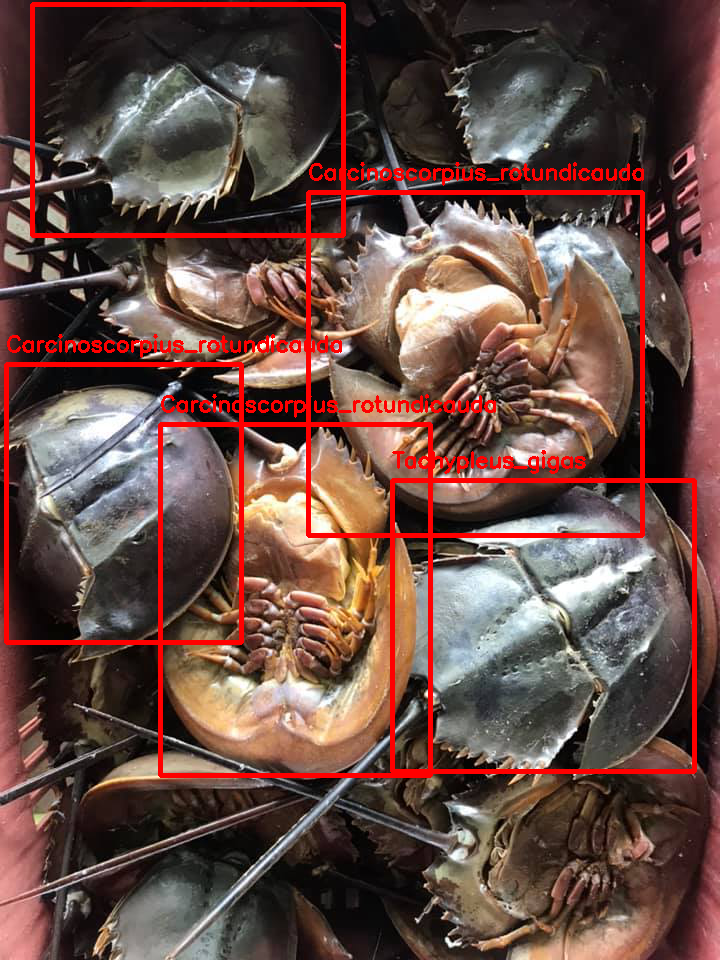

In [45]:
for img in Pre_imgs_array:
  display(img)

# Create a dataset
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

# Batch Inference
infer_dl = model_type.infer_dl(infer_ds, batch_size=16, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

In [ ]:
# Create a dataset
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

# Batch Inference
infer_dl = model_type.infer_dl(infer_ds, batch_size=1, shuffle=True)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


In [ ]:
device=next(model.parameters()).device
device

device(type='cpu')

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


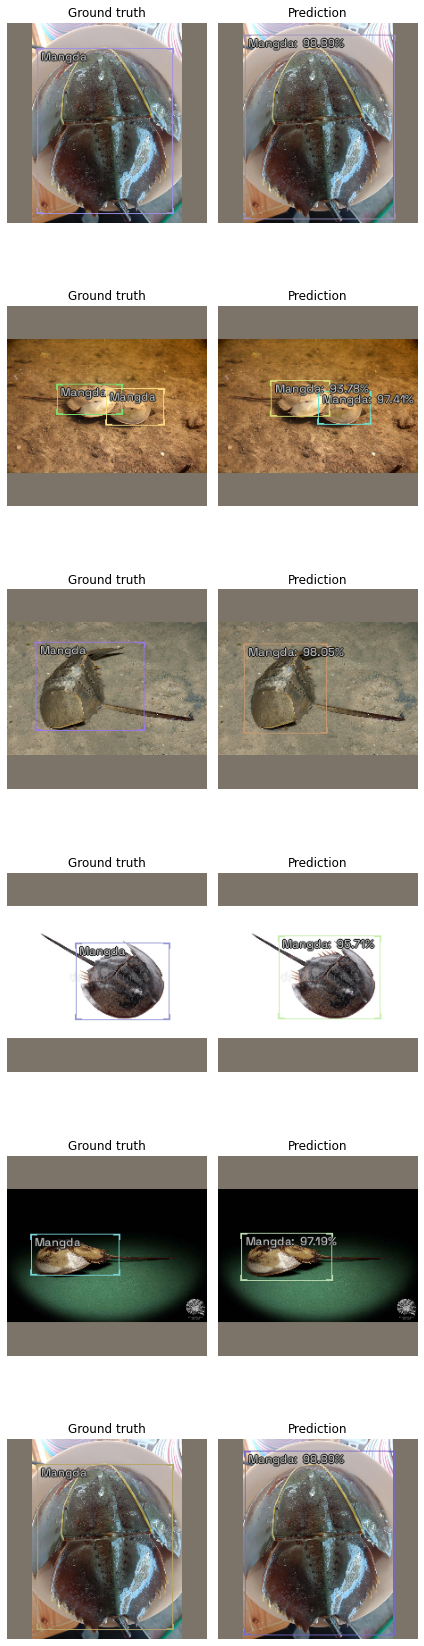

In [ ]:
model_type.show_results(model_loaded["model"], valid_ds, detection_threshold=0.6)